In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


Y = dataset.species
X = dataset.drop(columns='species')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

distribuitions = dict(C=uniform(), decision_function_shape=['ovo','ovr'])

clf = RandomizedSearchCV( SVC(random_state=42), distribuitions,random_state=42, n_iter=4)
clf.fit(X_train, Y_train)
print(clf.best_params_)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

# Análise do dataset de observação de pássaros



### Objetivo
O objetivo desse projeto é utilizar a maior quantidade possível das técnicas apresentadas em sala para atingir bons resultados nas predições da espécie da ave, dados a localização (latitude e longitude) e período do ano.

Além disso, é possível utilizar uma outra abordagem e criar modelos para prever a espécie adicionando também informações como Ordem, Família e Gênero do animal observado. Essa abordagem poderia ser utilizada para completar o conjunto de dados já que existem exemplos onde apenas a espécie não foi identificada.

### Descrição do dataset
Esse dataset é um subconjunto do eBird. O eBird é uma organização que armazena dados históricos de observação de pássaros do mundo todo. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Vamos iniciar realizando uma exploração e preparação inicial do conjunto de dados
* Para realizar a leitura dos dados, utilizaremos a biblioteca pandas
* Para fazer plots que auxiliem a análise dos dados, utilizaremos as bibliotecas matplotlib e seaborn
* Para gerar modelos e realizar testes, utilizaremos a biblioteca SkLearn

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [0]:
%%time
dataset = pd.read_csv('/content/drive/My Drive/DataScience/initial_dataset.csv', sep='\t')

CPU times: user 40.2 s, sys: 6.96 s, total: 47.1 s
Wall time: 1min 5s


Pelo tempo de demora na leitura do dataset, podemos ver que é um dataset grande e provavelmente teremos que segmentá-lo para conseguir trabalhar de forma mais eficiente. Vamos ver em seguida, quantos exemplos constituem esse dataset

In [0]:
dataset.shape

(4023507, 50)

#### Análise inicial de features que podem ser descartadas
A princípio, vamos procurar por features que tenham o mesmo valor em todos os exemplos. Podemos removê-las, já que não têm utilidade para distinguir classes.
Posteriormente, analisaremos também features que não possuam representatividade para os modelos, para identificar se poderemos remover mais algumas colunas

In [0]:
dataset.columns

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'verbatimScientificNameAuthorship', 'countryCode', 'locality',
       'stateProvince', 'occurrenceStatus', 'individualCount',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')

In [0]:
single_value_columns = []
for column in dataset.columns:
    if len(dataset[column].unique()) == 1:
        single_value_columns.append(column)
single_value_columns

['datasetKey',
 'kingdom',
 'phylum',
 'class',
 'infraspecificEpithet',
 'verbatimScientificNameAuthorship',
 'countryCode',
 'occurrenceStatus',
 'publishingOrgKey',
 'coordinateUncertaintyInMeters',
 'coordinatePrecision',
 'elevation',
 'elevationAccuracy',
 'depth',
 'depthAccuracy',
 'basisOfRecord',
 'institutionCode',
 'recordNumber',
 'identifiedBy',
 'dateIdentified',
 'license',
 'rightsHolder',
 'typeStatus',
 'establishmentMeans',
 'mediaType']

In [0]:
dataset.drop(columns=single_value_columns, inplace=True) # Removendo colunas que não serão utilizadas

In [0]:
dataset.to_csv('/content/drive/My Drive/DataScience/dataset_without_single_value_columns.csv', index=False) # Gravando novo dataset para ser utilizado, pois possui menor tamanho

In [0]:
%%time
dataset = pd.read_csv('/content/drive/My Drive/DataScience/dataset_without_single_value_columns.csv')

CPU times: user 19.3 s, sys: 2.21 s, total: 21.5 s
Wall time: 25.5 s


Já é possível notar alguma melhora, porém o tempo de leitura ainda é elevado.
Vamos analizar agora algumas colunas e seus significados para manter somente features relevantes para o problema

Agora vamos analisar as colunas remanescentes para manter apenas as colunas de interesse

In [0]:
dataset.columns

Index(['gbifID', 'occurrenceID', 'order', 'family', 'genus', 'species',
       'taxonRank', 'scientificName', 'verbatimScientificName', 'locality',
       'stateProvince', 'individualCount', 'decimalLatitude',
       'decimalLongitude', 'eventDate', 'day', 'month', 'year', 'taxonKey',
       'speciesKey', 'collectionCode', 'catalogNumber', 'recordedBy',
       'lastInterpreted', 'issue'],
      dtype='object')

In [0]:
dataset.iloc[1, :]

gbifID                                                            181560025
occurrenceID                              URN:catalog:CLO:EBIRD:OBS55048662
order                                                         Passeriformes
family                                                            Icteridae
genus                                                             Molothrus
species                                               Molothrus bonariensis
taxonRank                                                           SPECIES
scientificName                         Molothrus bonariensis (Gmelin, 1789)
verbatimScientificName                                Molothrus bonariensis
locality                  Foz do Iguazu and Parque Provincial Urugua-i, ...
stateProvince                                                        Paraná
individualCount                                                           1
decimalLatitude                                                    -25.5841
decimalLongi

Vamos agora, remover todas as colunas que não são de interesse para o problema. Ou seja, vamos manter Ordem, Família, Gênero, Espécie, Latitude, Longitude, Dia, Mês e Ano.

In [0]:
columns_to_drop = ['gbifID', 'occurrenceID', 'taxonRank', 'scientificName', 'verbatimScientificName', 'locality', 'stateProvince', 'individualCount', 'eventDate', 'taxonKey', 'speciesKey', 'collectionCode', 'catalogNumber', 'recordedBy', 'lastInterpreted', 'issue'] # colunas que não tem significado para os problemas
dataset.drop(columns=columns_to_drop, inplace=True)

In [0]:
dataset.columns

Index(['order', 'family', 'genus', 'species', 'decimalLatitude',
       'decimalLongitude', 'day', 'month', 'year'],
      dtype='object')

In [0]:
dataset.to_csv('/content/drive/My Drive/DataScience/dataset_without_columns.csv', index=False)

In [0]:
dataset.iloc[0]

order                       Passeriformes
family                          Icteridae
genus                           Molothrus
species             Molothrus bonariensis
decimalLatitude                  -25.6425
decimalLongitude                 -54.4383
day                                    17
month                                  10
year                                 2006
Name: 0, dtype: object

In [0]:
%%time
dataset = pd.read_csv('/content/drive/My Drive/DataScience/dataset_without_columns.csv')

CPU times: user 4.5 s, sys: 348 ms, total: 4.85 s
Wall time: 9.41 s


In [0]:
dataset.head()

,order,family,genus,species,decimalLatitude,decimalLongitude,day,month,year
0,Passeriformes,Icteridae,Molothrus,Molothrus bonariensis,-25.642455,-54.438286,17,10,2006
1,Passeriformes,Icteridae,Molothrus,Molothrus bonariensis,-25.584063,-54.581305,19,10,2006
2,Passeriformes,Icteridae,Molothrus,Molothrus bonariensis,-18.260979,-52.888398,25,10,2006
3,Passeriformes,Icteridae,Molothrus,Molothrus bonariensis,-18.260979,-52.888398,26,10,2006
4,Passeriformes,Icteridae,Molothrus,Molothrus bonariensis,-18.260979,-52.888398,27,10,2006


In [0]:
dataset.species.value_counts()

Sicalis flaveola             28429
Zonotrichia capensis         27866
Rupornis magnirostris        27602
Cyclarhis gujanensis         27352
Thraupis palmarum            27288
                             ...  
Turdus olivater                  1
Diomedea epomophora              1
Aeronautes montivagus            1
Phaethornis griseogularis        1
Bulweria bulwerii                1
Name: species, Length: 1207, dtype: int64

Podemos observar que existem espécies que apresentam baixo índice de observação. Por isso, vamos manter apenas as espécies que apresentam mais de 1000 observações. Isso significa que vamos reduzir o número de espécies para 700

In [0]:
df = pd.DataFrame()
for s in dataset.species.value_counts().index[:700]:
  df = pd.concat([A, dataset[dataset.species == s]])

In [0]:
df.shape

(3718315, 9)

In [0]:
df.to_csv('/content/drive/My Drive/DataScience/dataset_species_more_than_1000.csv', index=False)

In [0]:
%%time
dataset = pd.read_csv('/content/drive/My Drive/DataScience/dataset_species_more_than_1000.csv')

CPU times: user 4.12 s, sys: 214 ms, total: 4.33 s
Wall time: 5.26 s


Como a quantidade de dados continuou muito elevada, decidimos coletar somente 1000 exemplos de cada classe. Desse modo, também mantemos a mesma distribuição para cada classe, o que não acontecia anteriormente.

In [0]:
dataset.species.value_counts()

Pitangus sulphuratus      65595
Coragyps atratus          54812
Thraupis sayaca           41978
Tyrannus melancholicus    40735
Troglodytes aedon         40216
                          ...  
Selenidera gouldii         1042
Isleria hauxwelli          1041
Hylopezus nattereri        1039
Trogon collaris            1037
Tijuca atra                1034
Name: species, Length: 700, dtype: int64

In [0]:
df = pd.DataFrame()
for s in dataset.species.unique():
  df = pd.concat([A, dataset[dataset.species == s].sample(1000)]) # Escolha aleatória

In [0]:
df.species.value_counts()

Megarynchus pitangua         1000
Hemitriccus minor            1000
Pardirallus nigricans        1000
Opisthocomus hoazin          1000
Ramphotrigon megacephalum    1000
                             ... 
Milvago chimachima           1000
Sirystes sibilator           1000
Serpophaga nigricans         1000
Trogon curucui               1000
Lamprospiza melanoleuca      1000
Name: species, Length: 700, dtype: int64

In [0]:
df.to_csv('/content/drive/My Drive/DataScience/dataset_species_1000.csv', index=False)

In [0]:
%%time
dataset = pd.read_csv('/content/drive/My Drive/DataScience/dataset_species_1000.csv')

CPU times: user 629 ms, sys: 31.9 ms, total: 661 ms
Wall time: 700 ms


## Abordagem 1: identificação da espécie dados local e período da observação

Para realizar alguns testes de performance, vamos coletar aleatoriamente apenas alguns dados do conjunto, que ainda possui 700 mil exemplos e remover as coluns que não interessam para essa abordagem.

In [0]:
dataset = dataset.sample(5000, random_state=42)

In [0]:
Y = dataset.species
X = dataset.drop(columns=['order', 'family', 'genus', 'species'])

Separamos o dataset em treino e teste para fazer validação

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

### Testes
Vamos executar testes simples para ter noção do comportamento de classificadores 'cru', ou seja, sem modificar seus hiperparâmetros

In [0]:
from sklearn.svm import SVC

clf = SVC(random_state=42)
clf.fit(X_train, Y_train)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Finished training


(0.6665671641791044, 0.0048484848484848485)

In [0]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=42)
clf.fit(X_train, Y_train)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

(0.0029850746268656717, 0.0030303030303030303)

In [0]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, Y_train)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

(0.0662686567164179, 0.00909090909090909)

É possível ver que o SVM para classificação atinge um bom resultado no dataset de treino (0.66), porém não consegue manter um bom resultado no dataset de teste (0.004). Portanto, a partir desse momento utilizaremos apenas o SVM para realizar os demais testes

Com esses resultados, percebemos que há um elevado número de classes e, portanto, decidimos abordar apenas a classificação das espécies de um gênero de aves.

### Escolha de gênero
A seguir vamos escolher um gênero que poderá apresentar bons resultados. Escolheremos aquele que tiver uma quantidade boa de exemplos com uma quantidade razoável de espécies. 

In [0]:
top10_genus = dataset.genus.value_counts()[:10]
top10_genus

Turdus         96039
Thraupis       86038
Pitangus       69163
Patagioenas    62808
Columbina      60188
Coragyps       54812
Tyrannus       53989
Tangara        46516
Furnarius      40499
Troglodytes    40216
Name: genus, dtype: int64

In [0]:
n_species = []
for g in top10_genus.index:
  n_species.append(len(dataset[dataset.genus==g].species.unique()))
df = pd.concat([top10_genus.reset_index(),pd.Series(n_species, name='n_species')], axis=1)
df

,index,genus,n_species
0,Turdus,96039,14
1,Thraupis,86038,5
2,Pitangus,69163,2
3,Patagioenas,62808,6
4,Columbina,60188,5
5,Coragyps,54812,1
6,Tyrannus,53989,5
7,Tangara,46516,17
8,Furnarius,40499,4
9,Troglodytes,40216,1


Coletando os 10 generos com maior numero de exemplos, analisamos as possibilidades e julgamos o genero Thraupis como bom candidato, uma vez que esse genero possui um grande numero de exemplos e um numero razoavel de especies, o que facilitaria a classificacao destes.

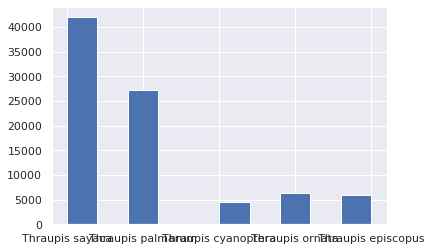

In [0]:
dataset[dataset.genus=='Thraupis'].species.hist()

In [0]:

dataset.species.value_counts()

Thraupis sayaca        41978
Thraupis palmarum      27288
Thraupis ornata         6310
Thraupis episcopus      6033
Thraupis cyanoptera     4429
Name: species, dtype: int64

Um histograma do genero Thraupis mostra que nao temos uma distribuicao que representa, por igual os exemplos de classes nele contido. Mesmo assim, vamos tentar classifica-lo.

### Classificação de dataset desbalanceado

In [0]:
%%time
dataset = pd.read_csv('/content/drive/My Drive/DataScience/dataset_without_columns.csv')

CPU times: user 4.22 s, sys: 381 ms, total: 4.6 s
Wall time: 5.87 s


In [0]:
df = dataset[dataset.genus=='Thraupis']
df.to_csv('/content/drive/My Drive/DataScience/dataset_thraupis.csv', index=False)


In [0]:
dataset = pd.read_csv('/content/drive/My Drive/DataScience/dataset_thraupis.csv')
dataset.drop(columns=['order','family','genus'],inplace=True)
dataset.head()

,species,decimalLatitude,decimalLongitude,day,month,year
0,Thraupis sayaca,-12.531591,-41.459039,3,7,2007
1,Thraupis sayaca,-20.373600,-46.277500,23,11,2018
2,Thraupis palmarum,-23.441831,-46.553154,21,11,2018
3,Thraupis sayaca,-14.680479,-39.377468,29,6,2007
4,Thraupis sayaca,-24.069189,-46.566213,23,11,2018


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

Y = dataset.species
X = dataset.drop(columns='species')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)


clf = SVC(random_state=42)
clf.fit(X_train, Y_train)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Finished training


(0.6430739873362824, 0.5658084739196281)

É possível notar uma grande melhora na performance de validação. Mas ainda temos que levar em conta que o dataset está desbalanceado, e o baseline é cerca de 50%.

Agora, para fins de comparacao, repetimos a operacao contando, dessa vez, com um conjunto limitado de representantes de cada classe para o numero de representantes da classe com menor numero de exemplos.

### Classificação com dataset balanceado

In [0]:
df = pd.DataFrame()
for s in dataset.species.unique():
  df = pd.concat([df, dataset[dataset.species == s].sample(4429, random_state=42)]) # Escolha aleatória
dataset = df

In [0]:
Y = dataset.species
X = dataset.drop(columns='species')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [0]:
clf = SVC(random_state=42)
clf.fit(X_train, Y_train)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Finished training


(0.7086338208532722, 0.5493979200875753)

Apesar do resultado no conjunto de teste ter sido um pouco inferior se comparado com o dataset desbalanceado, houve melhora na classificação, pois o baseline do dataset balanceado é 20%

Sendo assim, é possível perceber que o balanceamento do dataset realmente influencia na performance do modelo.

## Feature Importance
Vamos agora verificar a importância das features para realizar testes com todas a features e sem features, a fim de comparar os resultados

In [0]:
Y = dataset.species
X = dataset.drop(columns='species')

In [0]:
X.head()

,decimalLatitude,decimalLongitude,day,month,year
1177,-20.350180,-41.264251,14,7,2017
62602,-23.566741,-46.718684,18,8,2016
77373,-22.962641,-48.412735,21,4,2018
27938,-23.570100,-46.712172,3,10,2017
24947,-22.411787,-43.032824,11,11,2016


In [0]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=5)
selector.fit(X, Y)
[round(score) for score in selector.scores_]

[12075.0, 4594.0, 5.0, 21.0, 37.0]

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=5)
selector.fit(X, Y)
selector.scores_

array([0.76945291, 0.65229363, 0.00197873, 0.08232709, 0.119296  ])

Observa-se que as features com maiores importância são Latitude e Longitude em ambos os métodos utilizados. Portanto, vamos realizar testes apenas com esses dois atributos

### Testes com apenas Latitude e Longitude

#### Dataset desbalanceado

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('/content/drive/My Drive/DataScience/dataset_thraupis.csv')
dataset.drop(columns=['order','family','genus'],inplace=True)

Y = dataset.species
X = dataset.drop(columns=['species', 'day', 'month', 'year'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

clf = SVC(random_state=42)
clf.fit(X_train, Y_train)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Finished training


(0.6036950299245382, 0.6011693022928186)

#### Dataset balanceado

In [0]:
df = pd.DataFrame()
for s in dataset.species.unique():
  df = pd.concat([df, dataset[dataset.species == s].sample(4429, random_state=42)]) # Escolha aleatória
dataset = df

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

Y = dataset.species
X = dataset.drop(columns=['species', 'day', 'month', 'year'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

clf = SVC(random_state=42)
clf.fit(X_train, Y_train)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Finished training


(0.620273640223765, 0.6201423097974822)

## Busca de melhores parâmetros

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


Y = dataset.species
X = dataset.drop(columns='species')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

distribuitions = dict(C=uniform(), decision_function_shape=['ovo','ovr'])

clf = RandomizedSearchCV( SVC(random_state=42), distribuitions,random_state=42, n_iter=4)
clf.fit(X_train, Y_train)
print(clf.best_params_)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


Y = dataset.species
X = dataset.drop(columns='species')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

distribuitions = dict(C=uniform())

clf = RandomizedSearchCV(SVC(random_state=42), distribuitions,random_state=42, n_iter=1)
clf.fit(X_train, Y_train)
print(clf.best_params_)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in v

{'C': 0.3745401188473625}
Finished training


(0.5377771786749342, 0.5270935960591133)

## Teste com normalização de dataset

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

Y = dataset.species
X = dataset.drop(columns=['species', 'day', 'month', 'year'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

clf = SVC(random_state=42)
clf.fit(X_train, Y_train)
print('Finished training')
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Finished training


(0.620273640223765, 0.6201423097974822)

## Plots básicos para visualizar espaço

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
c = LabelEncoder().fit_transform(Y.values.tolist())
c

array([4, 4, 4, ..., 1, 1, 1])

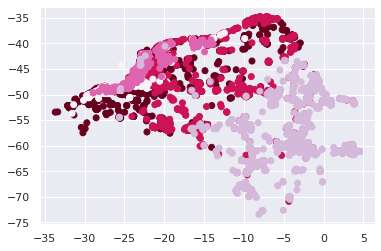

In [0]:
plt.scatter(X.decimalLatitude, X.decimalLongitude, c=c, cmap='PuRd')

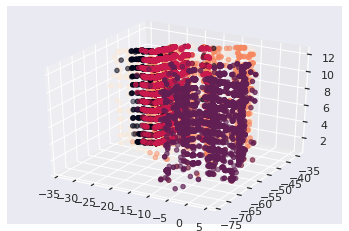

In [0]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
#ax.scatter3D(X.decimalLatitude.values,X.decimalLongitude.values)
#ax.set_xlabel("Latitude")
#ax.set_ylabel("Longitude")

ax.scatter(X.decimalLatitude.values,X.decimalLongitude.values,X.month.values, c=c, )
plt.show()